# setup

In [2]:
#setup
import math

# create class to hold drug info
class DrugInfo:
    def __init__(self, name, drug_id, sens_cut, res_cut):
        self.name = name
        self.id = drug_id
        self.sens_cut = sens_cut
        self.res_cut = res_cut

    def __repr__(self):
        return f"Drug(name={self.name!r}, id={self.id!r}, sens_cut={self.sens_cut:.2f}, res_cut={self.res_cut:.2f})"

# set data extraction used for rest of code
# setup cisplatin using drug_id 1005, sensitivity cutoffs as determined by manual review from literature
drug = DrugInfo(name="cisplatin", drug_id = '1005', sens_cut=math.log(10), res_cut=math.log(30))
 #use meta_df to find drug id for changing it

# cancer type studies for analysis
cancer_type = 'HNSC'
# cell lines with intermediate senstivity grouped with....
set_intermediate_as = 'resistant'
# nearest cell lines from gene expression to add if any
ADD_NEAREST = 5
# pre-defined list of genes to use for HNSC
hnsc_select_genes = ['TBC1D1','CPEB3','KLRG1','EPB41L4B','RAB38','DSG3','DCAF10','SYT7','AFTPH','RRAGC','ERCC3','NLRP1','SEC13','WDR46','STK11IP','DENND4C','PLEKHF1','TONSL','EFNA1','ZCCHC7']

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats as ss
import numpy as np
import seaborn as sns
np.random.seed(123) #ensure reproducibility

In [4]:
# load lifelines for survival analysis and KaplanMeier curves
from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter
from lifelines.statistics import multivariate_logrank_test
from lifelines.plotting import add_at_risk_counts

## TCGA

Load, preprocess data

In [7]:
# download TCGA data
# expression by gene
# !wget https://toil-xena-hub.s3.us-east-1.amazonaws.com/download/tcga_RSEM_gene_tpm.gz
# expression probemap
# !wget https://toil-xena-hub.s3.us-east-1.amazonaws.com/download/probeMap%2Fgencode.v23.annotation.gene.probemap
# survival data
# !wget https://tcga-pancan-atlas-hub.s3.us-east-1.amazonaws.com/download/Survival_SupplementalTable_S1_20171025_xena_sp

# mutation - mutation-based analysis ???
#!wget https://tcga-pancan-atlas-hub.s3.us-east-1.amazonaws.com/download/mc3.v0.2.8.PUBLIC.nonsilentGene.xena.gz

# copy number by gene - gene amplification/deletion data 
#!wget https://tcga-pancan-atlas-hub.s3.us-east-1.amazonaws.com/download/broad.mit.edu_PANCAN_Genome_Wide_SNP_6_whitelisted.gene.xena.gz

# protein expression by gene - protein-level expression not related for survival modelling (RPPA) 
# !wget https://tcga-pancan-atlas-hub.s3.us-east-1.amazonaws.com/download/TCGA-RPPA-pancan-clean.xena.gz

# drug treatment data
# from urllib.request import urlopen
url = 'https://dl.dropbox.com/scl/fi/5ys57nybgd7x3d8qdkcde/tcga_scc_chemo.zip?rlkey=51e3c12aqypus0xmmdkztqn3q&dl=1'
#open('tcga_scc_chemo.zip', 'wb').write(urlopen(url).read())
#!unzip tcga_scc_chemo.zip

In [ ]:
### TCGA data ###
meta_df = pd.read_csv('Survival_SupplementalTable_S1_20171025_xena_sp', sep='\t')
# count samples per type
meta_df.groupby('cancer type abbreviation').agg({'sample': 'nunique'})
# identify columns belonging to desired cancer type(s)
types_to_keep = {cancer_type}
columns_to_keep = set(['sample'] + meta_df[meta_df['cancer type abbreviation'].isin(types_to_keep)]['sample'].tolist())
meta_df = meta_df[meta_df['cancer type abbreviation'].isin(types_to_keep)]
meta_df.index = meta_df['sample']
select = 'expression'

if select=='alteration':
    # copy number data frame
    cn_matrix = pd.read_csv('broad.mit.edu_PANCAN_Genome_Wide_SNP_6_whitelisted.gene.xena.gz', compression='gzip', sep='\t', usecols=lambda x: x in columns_to_keep)
    cn_matrix = cn_matrix.rename(columns={'sample': 'gene'})
    cn_matrix = cn_matrix.set_index('gene')
    # convert to copy number - initially log(tumour/normal)
    cn_matrix = np.exp(cn_matrix)
    # snv data
    mut_matrix = pd.read_csv('mc3.v0.2.8.PUBLIC.nonsilentGene.xena.gz', compression='gzip', sep='\t', usecols=lambda x: x in columns_to_keep)
    mut_matrix = mut_matrix.rename(columns={'sample': 'gene'})
    mut_matrix = mut_matrix.set_index('gene')
    # count overlap samples
    valid_samples_alt = set(cn_matrix.columns.values).intersection(set(mut_matrix.columns.values))
    l_alt = len(valid_samples_alt)
    stype = 'OS'
    valid_samples_surv = set(meta_df.loc[:,[stype + ".time",stype]].dropna().index.values)
    l_surv = len(valid_samples_surv)
    valid_samples_both = valid_samples_alt.intersection(valid_samples_surv)
    l_both = len(valid_samples_both)
    print('number of ' + str(types_to_keep) + ' for alterations: '+ str(l_alt))
    print('number of ' + str(types_to_keep) + ' for survival: ' + str(l_surv))
    print('nubmer of ' + str(types_to_keep) + ' with both: ' + str(l_both))
    
if select=='expression':
    # expr dataframe
    exp_matrix = pd.read_csv('tcga_RSEM_gene_tpm.gz', compression='gzip', sep='\t', usecols=lambda x: x in columns_to_keep)
    exp_matrix = exp_matrix.rename(columns={'sample': 'gene'})
    exp_matrix = exp_matrix.set_index('gene')
    id2gene = pd.read_csv('probeMap%2Fgencode.v23.annotation.gene.probemap', sep='\t') # 
    exp_matrix = exp_matrix.set_index(pd.Index(id2gene.gene))
    valid_samples_exp = set(exp_matrix.columns)
    l_exp = len(valid_samples_exp)
    stype = 'OS'
    valid_samples_surv = set(meta_df.loc[:,[stype + ".time",stype]].dropna().index.values)
    l_surv = len(valid_samples_surv)
    valid_samples_both = valid_samples_exp.intersection(valid_samples_surv)
    l_both = len(valid_samples_both)
    print('number of ' + str(types_to_keep) + ' for expression: '+ str(l_exp))
    print('number of ' + str(types_to_keep) + ' for survival: ' + str(l_surv))
    print('number of ' + str(types_to_keep) + ' with both: ' + str(l_both))


# we need chemotherapy treatment data (not included in default data)
tcga_drug_path = 'tcga_drug_' + cancer_type.lower() + '.csv'
tcga_drug = pd.read_csv(tcga_drug_path, skiprows=1)
tcga_drug.drop(index=0, inplace=True)
tcga_drug['bcr_patient_barcode'] = tcga_drug['bcr_patient_barcode'].astype(str) + '-01'
tcga_drug.set_index('bcr_patient_barcode', inplace=True)
tcga_drug

# chemonaive = not in drug index (ie did not receive any chemotherapy treatment)
tcga_naive = list(valid_samples_exp - set(tcga_drug.index.values))
# only cisplatin, started within 3 months
# ever any platin (NB does not filter out patients given other drugs, or enforce start date for platin drug)
tcga_platin = tcga_drug[tcga_drug['drug_name'].str.lower().str.contains('platin')].index
print(f"number of {str(types_to_keep)} chemonaive: {len(tcga_naive)}")
print(f"number of {str(types_to_keep)} ever -platin treated: {len(tcga_platin)}")
naive_df = pd.DataFrame({'class': ['chemonaive'] * len(tcga_naive)}, index=tcga_naive)
platin_df = pd.DataFrame({'class': ['platin'] * len(tcga_platin)}, index=tcga_platin)
tcga_class = pd.concat([naive_df, platin_df])

number of {'HNSC'} for expression: 564
number of {'HNSC'} for survival: 603
number of {'HNSC'} with both: 563
number of {'HNSC'} chemonaive: 381
number of {'HNSC'} ever -platin treated: 182


In [ ]:
exp_matrix

# columns are patient barcodes / identifiers
# rows are expression levels (tpm-normalized) per gene name (taken from ensembleIDs mapped to gene names in the probemap)

,TCGA-DQ-5624-01,TCGA-DQ-7591-01,TCGA-CV-5976-01,TCGA-CV-6948-01,TCGA-CV-A6K0-01,TCGA-BA-6870-01,TCGA-CV-6955-01,TCGA-P3-A5Q6-01,TCGA-QK-A64Z-01,TCGA-IQ-A61O-01,...,TCGA-CN-6011-01,TCGA-CV-5432-01,TCGA-CQ-5324-01,TCGA-CV-5436-01,TCGA-QK-A6VC-01,TCGA-BB-7863-01,TCGA-P3-A5Q5-01,TCGA-BB-4217-01,TCGA-TN-A7HJ-01,TCGA-CR-6470-01
gene,,,,,,,,,,,,,,,,,,,,,
DDX11L1,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,...,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658
WASH7P,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,...,-9.9658,-9.9658,-9.9658,-9.9658,-3.1714,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658
MIR6859-1,-9.9658,-6.5064,-6.5064,-9.9658,-2.3884,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,...,-9.9658,-9.9658,-9.9658,-9.9658,-6.5064,-9.9658,-9.9658,-3.4580,-5.5735,-9.9658
RP11-34P13.3,5.1260,5.5258,5.1486,4.1417,5.2358,3.9920,4.6422,4.2654,5.3495,4.9704,...,4.8714,4.5497,5.2533,4.0960,5.4016,3.7877,5.7154,4.8963,4.7132,5.1293
MIR1302-2,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,...,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658,-9.9658
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MT-ND6,-2.8262,-9.9658,-9.9658,-2.4659,-1.5105,-4.0350,-3.6259,-3.6259,-3.3076,-9.9658,...,-9.9658,-2.8262,-9.9658,-9.9658,-9.9658,-9.9658,-3.6259,-9.9658,-9.9658,-9.9658
MT-TE,5.4867,5.5717,5.4964,5.2891,5.5230,4.3442,5.1006,4.6708,5.5126,4.4483,...,6.0295,4.9746,6.3338,5.4572,4.9668,4.6921,5.4223,6.2548,5.2548,5.7955
MT-CYB,-4.2934,-2.7274,-5.5735,-2.7274,-4.2934,-5.5735,-4.2934,-1.9379,-3.3076,-5.5735,...,-2.8262,-9.9658,-2.1779,-2.9324,-1.8836,-3.0469,-3.3076,-2.0529,-1.9379,-1.5522


## GDSC

In [ ]:
### GDSC data ###
# # old version
# ic50_1 = pd.read_excel('ftp://ftp.sanger.ac.uk/pub/project/cancerrxgene/releases/current_release/GDSC1_fitted_dose_response_24Jul22.xlsx')
# ic50_2 = pd.read_excel('ftp://ftp.sanger.ac.uk/pub/project/cancerrxgene/releases/current_release/GDSC2_fitted_dose_response_24Jul22.xlsx') # gdsc_1
# drug_data = pd.read_csv('ftp://ftp.sanger.ac.uk/pub/project/cancerrxgene/releases/current_release/screened_compounds_rel_8.4.csv')
# cell_data = pd.read_excel('ftp://ftp.sanger.ac.uk/pub/project/cancerrxgene/releases/current_release/Cell_Lines_Details.xlsx')

# TODO update GDSC data to later data
### newer links

# expression data (separate) for gdsc (Robust microarray average to map gene titles/symbols and expression levels to identifiers in cell lines (cosmic id used to map to expression in the IC50 set))
""" !wget https://www.cancerrxgene.org/gdsc1000/GDSC1000_WebResources//Data/preprocessed/Cell_line_RMA_proc_basalExp.txt.zip
gdsc_exp_matrix = pd.read_csv('Cell_line_RMA_proc_basalExp.txt.zip',compression='zip',sep="\t") """

ic50_1 = pd.read_excel('./data/chemo/GDSC1_fitted_dose_response_27Oct23.xlsx')
ic50_2 = pd.read_excel('./data/chemo/GDSC2_fitted_dose_response_27Oct23.xlsx')
drug_data = pd.read_csv('./data/chemo/screened_compounds_rel_8.5.csv')
cell_data = pd.read_excel('./data/chemo/Cell_Lines_Details.xlsx')

# process drug treatment and drug data 
ic50 = pd.concat([ic50_1,ic50_2],axis=0)
ic50 = ic50.astype({'DRUG_ID': 'string'})
ic50 = ic50.pivot_table(index='DRUG_ID', columns='COSMIC_ID', values='LN_IC50',aggfunc='mean')

# load metadata for drug data - merge on drug id from set drug class corresponding to the ln_ic50 values in ic50 
drug_data = drug_data.astype({'DRUG_ID': 'string'})
drug_data.set_index('DRUG_ID',inplace=True)

# load metadata (about cells) 
gdsc_meta = cell_data.drop(['Whole Exome Sequencing (WES)','Copy Number Alterations (CNA)','Gene Expression','Methylation','Drug\nResponse','Screen Medium','Growth Properties'],axis=1)
gdsc_meta.rename(columns={'GDSC\nTissue descriptor 1': 'tissue',
                               'GDSC\nTissue\ndescriptor 2': 'site',
                               'Cancer Type\n(matching TCGA label)':'cancer_type',
                               'Microsatellite \ninstability Status (MSI)':'msi',
                               'COSMIC identifier':'sample'},inplace=True) # changes cosmic identifier to sample 
gdsc_meta.drop(gdsc_meta[gdsc_meta['sample'].isnull()].index,inplace=True)
gdsc_meta = gdsc_meta.astype({'sample': 'int32'})
gdsc_meta.set_index('sample',inplace=True)

# skip alteration data for simple expression data
if 1 == 0:
    gdsc_mut_raw = pd.read_csv('gdsc_mut_simple.csv.gz',compression='gzip')
    gdsc_mut_raw['gene'].replace('_ENST[0-9]*', '', regex=True,inplace=True)
    gdsc_mut_raw['values'] = [1] * len(gdsc_mut_raw.index)
    gdsc_mut_matrix = gdsc_mut_raw.pivot_table(index="gene",columns=["ID_sample"],values="values",fill_value='0',aggfunc=max)
    gdsc_mut_matrix = gdsc_mut_matrix.astype('int64',copy=False)

    gdsc_cn_raw = pd.read_csv('simple_cnv.txt',sep="\t")
    gdsc_cn_raw['gene_name'].replace('_ENST[0-9]*', '', regex=True,inplace=True)
    gdsc_cn_matrix = gdsc_cn_raw.pivot_table(index="gene_name",columns=["ID_SAMPLE"],values="MUT_TYPE",fill_value='neutral',aggfunc=max)
    recode = {'loss': 0.25, 'neutral':1,'gain':2}
    gdsc_cn_matrix.replace(recode,inplace=True)

# load expression data
gdsc_exp_matrix = pd.read_csv('Cell_line_RMA_proc_basalExp.txt.zip',compression='zip',sep="\t")
gdsc_exp_matrix.rename(columns={'GENE_SYMBOLS': 'gene'},inplace=True)
gdsc_exp_matrix.set_index('gene',inplace=True)
gdsc_exp_matrix.drop('GENE_title',axis=1,inplace=True)
gdsc_exp_matrix.columns = gdsc_exp_matrix.columns.str.lstrip('DATA.')
# exclude genes with blank names
gdsc_exp_matrix = gdsc_exp_matrix.reset_index().dropna(subset=['gene']).set_index('gene')

# match metadata and expression data
# gdsc_meta.index = gdsc_meta.index.astype(str)
gdsc_exp_matrix.columns = gdsc_exp_matrix.columns.astype(float)
valid_samples = list(set(gdsc_meta.index).intersection(gdsc_exp_matrix.columns))
valid_samples = list(set(gdsc_meta.index).intersection(gdsc_exp_matrix.columns).intersection(ic50.columns))
gdsc_meta = gdsc_meta.loc[valid_samples]
gdsc_exp_matrix = gdsc_exp_matrix[valid_samples]
ic50 = ic50[valid_samples]

/Users/JanayeCheong/Documents/chemosensitivity project/CHEMOSENSITIVITY/.venv/lib/python3.13/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [ ]:
# cancer type for matching tcga label allows filtering of the type of cancer evaluated 
cell_data

,Sample Name,COSMIC identifier,Whole Exome Sequencing (WES),Copy Number Alterations (CNA),Gene Expression,Methylation,Drug\nResponse,GDSC\nTissue descriptor 1,GDSC\nTissue\ndescriptor 2,Cancer Type\n(matching TCGA label),Microsatellite \ninstability Status (MSI),Screen Medium,Growth Properties
0,A253,906794.0,Y,Y,Y,Y,Y,aero_dig_tract,head and neck,NaN,MSS/MSI-L,D/F12,Adherent
1,BB30-HNC,753531.0,Y,Y,Y,Y,Y,aero_dig_tract,head and neck,HNSC,MSS/MSI-L,D/F12,Adherent
2,BB49-HNC,753532.0,Y,Y,Y,Y,Y,aero_dig_tract,head and neck,HNSC,MSS/MSI-L,D/F12,Adherent
3,BHY,753535.0,Y,Y,Y,Y,Y,aero_dig_tract,head and neck,HNSC,MSS/MSI-L,D/F12,Adherent
4,BICR10,1290724.0,Y,Y,Y,Y,Y,aero_dig_tract,head and neck,HNSC,MSS/MSI-L,D/F12,Adherent
...,...,...,...,...,...,...,...,...,...,...,...,...,...
997,KP-2,1298218.0,Y,N,Y,N,Y,pancreas,pancreas,PAAD,NaN,D/F12,Adherent
998,KO52,1330932.0,Y,Y,N,N,N,leukemia,acute_myeloid_leukaemia,LAML,MSS/MSI-L,D/F12,NaN
999,SC-1,1331030.0,Y,Y,N,N,N,lymphoma,B_cell_lymphoma,DLBC,MSS/MSI-L,R,NaN
1000,U-CH2,1503373.0,Y,Y,N,N,N,bone,bone_other,NaN,MSS/MSI-L,D/F12,Adherent


In [ ]:
gdsc_meta 
# SAMPLE COLUMN BECOMES COSMIC IDENTIFIE
# SAMPLE NAME is cell line name  

,Sample Name,tissue,site,cancer_type,msi
sample,,,,,
907268,JiyoyeP-2003,lymphoma,Burkitt_lymphoma,NaN,MSS/MSI-L
907269,JVM-2,lymphoma,lymphoid_neoplasm other,CLL,MSS/MSI-L
907270,JVM-3,lymphoma,lymphoid_neoplasm other,CLL,MSS/MSI-L
907271,KALS-1,nervous_system,glioma,LGG,MSS/MSI-L
907272,KARPAS-45,leukemia,lymphoblastic_leukemia,ALL,MSS/MSI-L
...,...,...,...,...,...
753622,TE-10,aero_dig_tract,oesophagus,ESCA,MSS/MSI-L
753623,TE-8,aero_dig_tract,oesophagus,ESCA,MSS/MSI-L
753624,CAPAN-1,pancreas,pancreas,PAAD,MSS/MSI-L


In [ ]:
# after filtering valid samples / cell lines that are specified by the drug choice and valid cancer type 
gdsc_exp_matrix.head()

,907268.0,907269.0,907270.0,907271.0,907272.0,907273.0,907274.0,907275.0,907276.0,907277.0,...,909260.0,753620.0,753621.0,688086.0,688087.0,753622.0,753623.0,753624.0,917486.0,688121.0
gene,,,,,,,,,,,,,,,,,,,,,
TSPAN6,3.124325,3.080957,3.277868,7.961308,7.013419,3.169982,3.402521,3.224111,7.448062,6.160155,...,6.721406,6.654349,7.934029,3.181502,3.272601,8.383998,7.233982,7.450398,8.952270,7.800932
TNMD,2.793458,2.811509,2.731624,2.756488,3.219683,2.838866,3.027219,3.047482,2.887007,2.907307,...,3.078159,3.103354,3.024583,3.019871,2.886617,2.897575,3.020735,2.625546,2.967284,2.916731
DPM1,9.470730,10.417394,9.535938,10.197507,10.223459,10.345326,10.488287,9.969469,10.642938,10.129780,...,10.247438,10.139488,10.689404,10.086492,10.190728,10.264270,10.958178,10.598815,10.223329,9.121407
SCYL3,5.088753,4.608033,5.324709,3.712988,4.173391,5.061174,5.549816,4.112377,3.636842,4.078762,...,4.272515,3.759778,4.479769,4.139257,4.363556,4.075559,3.782566,4.709963,4.544521,3.723997
C1orf112,3.580823,3.928187,3.152041,3.648906,4.755369,3.941970,3.638371,4.065314,3.069534,4.648203,...,5.343099,3.576047,3.947679,3.418307,3.503112,3.882336,3.286766,3.600796,3.356574,3.375714


In [ ]:
### setup training data
from sklearn.neighbors import NearestNeighbors
# get cell lines matching cancer type
gdsc_sample_ids = gdsc_meta[(gdsc_meta['cancer_type'] == cancer_type)].index
# if we are adding nearest neighbours the add nearest neighbours based on expression data
if ADD_NEAREST > 0:
    nn_model = NearestNeighbors(n_neighbors=ADD_NEAREST)
    nn_model.fit(gdsc_exp_matrix.T)
    distances, indices = nn_model.kneighbors(gdsc_exp_matrix[gdsc_sample_ids].T)
    nearest_samples = indices[:, 1:]
    nearest_sample_ids = gdsc_exp_matrix.columns.values[nearest_samples].flatten()
    gdsc_sample_ids = np.unique(np.concatenate((gdsc_sample_ids,nearest_sample_ids)))

# Check for overlap in cell line metadata and ic50 data
gdsc_sample_ids = list(set(gdsc_sample_ids).intersection(set(ic50.columns)))
gdsc_ic50 = ic50.loc[drug.id,gdsc_sample_ids]
print(f"GDSC {cancer_type} samples, n= {len(gdsc_sample_ids)}")

# classify cell lines as sensitive or resistance
sample_data = pd.DataFrame(gdsc_ic50)
sample_data.columns = ['ic50']
sample_data['class'] = 'intermediate'
sample_data.loc[sample_data['ic50'] < drug.sens_cut,'class'] = 'sensitive'
sample_data.loc[sample_data['ic50'] >= drug.res_cut,'class'] = 'resistant'
print(f"of which {sample_data['class'].value_counts().get('sensitive', 0)} sensitive, {sample_data['class'].value_counts().get('resistant', 0)} resistant")
# group intermediate cell lines according to our preset
print(f"setting intermediate samples (n={sample_data['class'].value_counts().get('intermediate', 0)}) as {set_intermediate_as}")
sample_data.loc[sample_data['class']=='intermediate','class'] = set_intermediate_as
sample_data
# generate differentially expressed genes
# nb index need to be strings
sample_expr = gdsc_exp_matrix[sample_data.index]

GDSC HNSC samples, n= 77
of which 21 sensitive, 25 resistant
setting intermediate samples (n=31) as resistant


In [ ]:
# compare genes expression between sensitive and resistant lines
import pandas as pd
import numpy as np
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests

pvalues = []
log_fold_changes = []

# slowish could be rewritten to run as vectorised equation
for gene in sample_expr.index:
    class_1_expr = sample_expr.loc[gene,sample_data[sample_data['class'] == 'sensitive'].index]
    class_2_expr = sample_expr.loc[gene,sample_data[sample_data['class'] == 'resistant'].index]
    p = mannwhitneyu(class_1_expr,class_2_expr)[1]
    log_fold_change = np.log2((class_2_expr.mean() + 1) / (class_1_expr.mean() + 1))
    pvalues.append(p)
    log_fold_changes.append(log_fold_change)
# adjust p-values using FDR
fdr = multipletests(pvalues, method='fdr_bh')[1]

results = pd.DataFrame({
    'gene': sample_expr.index,
    'p_value': pvalues,
    'fdr': fdr,
    'log_fold_change': log_fold_changes
}).sort_values(by='p_value', ascending=True)
results

,gene,p_value,fdr,log_fold_change
10464,NUAK2,0.000143,0.878894,-0.128136
4453,RRAGC,0.000225,0.878894,-0.076710
8413,PNLDC1,0.000351,0.878894,-0.133928
8806,TAOK2,0.000475,0.878894,0.040431
3525,ANXA10,0.000564,0.878894,0.500144
...,...,...,...,...
4550,MTFR1L,1.000000,1.000000,0.007307
11954,MT1B,1.000000,1.000000,0.002795
4561,PPP1R8,1.000000,1.000000,-0.003384
16425,KRT25,1.000000,1.000000,0.015427


: 

In [ ]:
# Plot optimisation of number of genes selection
# we use stratifiedKFold for faster analysis, use loo for slower but more accuracte analysis
# multiple alternative approaches to gene (feature) selection, e.g. regularisation with elastic net, cluster based selection

if cancer_type == 'HNSC':
    import numpy as np
    import pandas as pd
    from sklearn.metrics import roc_auc_score
    from sklearn.model_selection import LeaveOneOut
    from sklearn.linear_model import LogisticRegression
    import matplotlib.pyplot as plt
    from sklearn.model_selection import StratifiedKFold
    gene_auc_scores = []

    # Loop over the number of genes (from 1 to 100)
    for n_genes in range(1, 101):
        # Step 1: Select the top `n_genes` from the 'results' DataFrame
        select_genes = results['gene'].head(n_genes).values

        # Step 2: Extract gene expression data for selected genes
        x = sample_expr.loc[select_genes].T  # Transpose to get samples in rows and genes in columns

        # Step 3: Extract the class labels
        y = sample_data.loc[x.index, 'class']  # Align class labels with expression data

        # Step 4: Initialize Leave-One-Out Cross-Validation
        loo = LeaveOneOut()
        skf = StratifiedKFold(n_splits=5)
        aucs = []

        # Step 5: Perform LOOCV
        for train_index, test_index in skf.split(x,y):
            x_train, x_test = x.iloc[train_index], x.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]

            # Train logistic regression model
            model = LogisticRegression()
            model.fit(x_train, y_train)

            # Predict probabilities for the test sample
            y_pred_prob = model.predict_proba(x_test)[:, 1]  # Probability for class 'sensitive'

            # Calculate the AUC for this fold
            auc = roc_auc_score(y_test, y_pred_prob)
            aucs.append(auc)

        # Step 6: Store the average AUC for this number of genes
        avg_auc = np.mean(aucs)
        gene_auc_scores.append(avg_auc)

    # Step 7: Plot the AUC as a function of the number of genes
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, 101), gene_auc_scores, marker='o')
    plt.title('AUC vs. Number of Genes')
    plt.xlabel('Number of Genes')
    plt.ylabel('AUC')
    plt.grid(True)
    plt.show()

In [ ]:
#select genes (top 20)
select_genes = results['gene'].values[:20]
#check they exist in tcga
select_genes = list(set(select_genes).intersection(set(exp_matrix.index)))
print(f'selecting: {len(select_genes)} genes')

selecting: 20 genes


In [ ]:
# if we want to skip and use the predefined list of genes
# select_genes = hnsc_select_genes

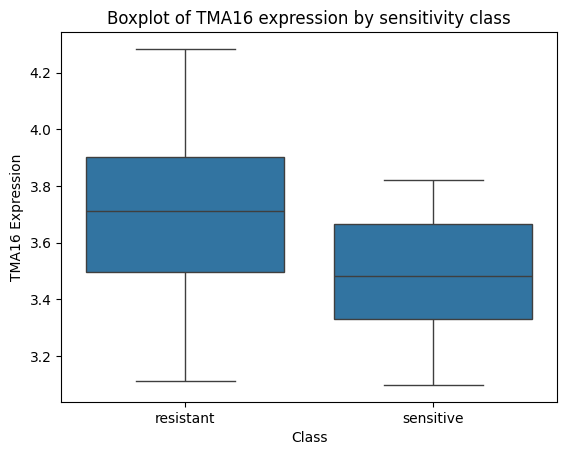

In [ ]:
# compare sample gene across sensitivity classes
import seaborn as sns
import matplotlib.pyplot as plt
gene = select_genes[1]
gene_expr = sample_expr.loc[gene].values
sample_class = sample_data['class'].values
sns.boxplot(x=sample_class, y=gene_expr)
plt.title(f'Boxplot of {gene} expression by sensitivity class')
plt.xlabel('Class')
plt.ylabel(f'{gene} Expression')
plt.show()

In [ ]:
# problem with certain genes in ESCA data, manually corrected here by excluding them
if cancer_type == 'ESCA':
    select_genes = [gene for gene in select_genes if gene != 'H1FX']
    select_genes = [gene for gene in select_genes if gene != 'NET1']
    select_genes = [gene for gene in select_genes if gene != 'OSBPL9']
    select_genes = [gene for gene in select_genes if gene != 'SUSD3']
    select_genes = [gene for gene in select_genes if gene != 'C19orf80']
    select_genes = [gene for gene in select_genes if gene != 'OR52J3']
    select_genes = [gene for gene in select_genes if gene != 'UEVLD']
    select_genes = [gene for gene in select_genes if gene != 'KRTAP4-9']
    select_genes = [gene for gene in select_genes if gene != 'BMP8B']
# select_genes = select_genes[1:5]


''

/usr/local/lib/python3.10/dist-packages/lifelines/utils/__init__.py:1100: ConvergenceWarning: Column(s) ['EPB41L4B', 'FAM153C', 'WNT16', 'SRCAP', 'RRAGC', 'ANXA10', 'CGB8', 'NUAK2'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/usr/local/lib/python3.10/dist-packages/lifelines/utils/__init__.py:1100: ConvergenceWarning: Column(s) ['EPB41L4B', 'FAM153C', 'WNT16', 'SRCAP', 'RRAGC', 'ANXA10', 'CGB8', 'NUAK2'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/usr/local/lib/python3.10/dist-packages/lifelines/utils/__init__.py:1100: ConvergenceWarning: Column(s) ['EPB41L4B', 'FAM153C', 'WNT16',

TCGA-DQ-7594-01    high
TCGA-CN-A49A-01    high
TCGA-QK-A8Z7-01    high
TCGA-DQ-7591-01    high
TCGA-D6-A6EK-01     low
                   ... 
TCGA-CN-5374-01    high
TCGA-BA-A4IF-01     low
TCGA-TN-A7HL-01    high
TCGA-BA-A6DJ-01     low
TCGA-MZ-A6I9-01    high
Length: 149, dtype: object


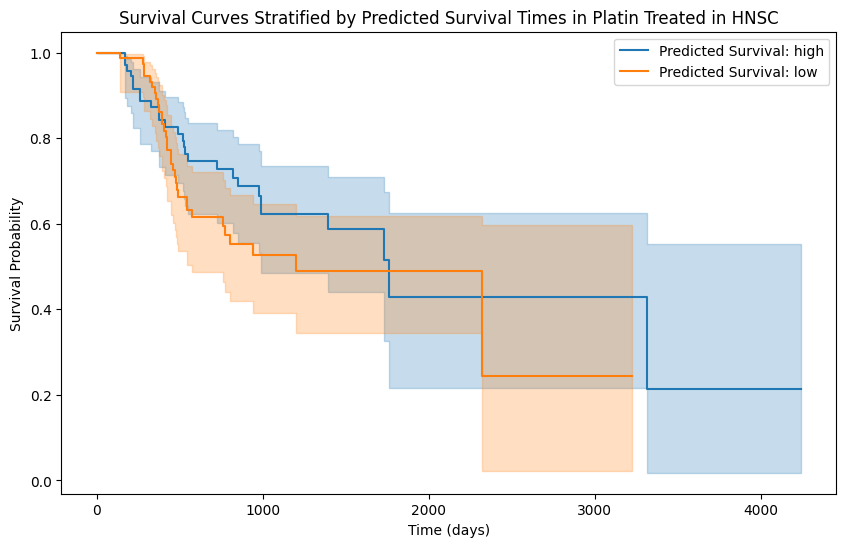

In [ ]:
import pandas as pd
from lifelines import CoxPHFitter
from sklearn.model_selection import LeaveOneOut
import numpy as np

# Filter data to include only platin class, NB this is not ONLY platin, does not exclude patients given other drugs
platin_samples = tcga_class[tcga_class['class'] == 'platin'].index
valid_samples = list(set(platin_samples).intersection(set(exp_matrix.columns)))
exp_platin = exp_matrix.loc[select_genes, valid_samples]
meta_platin = meta_df.loc[valid_samples]

# Ensure there are no NaN values in the relevant columns
meta_platin_clean = meta_platin.dropna(subset=['OS', 'OS.time'])
exp_platin_clean = exp_platin[meta_platin_clean.index]

# Add survival time and event indicator to the gene expression data
exp_platin_clean = exp_platin_clean.T  # Transpose to have samples as rows
survival_data = meta_platin_clean[['OS.time', 'OS']].copy()
combined_data = exp_platin_clean.join(survival_data)

# Initialize the Cox Proportional Hazards model
cph = CoxPHFitter()
cph = CoxPHFitter(penalizer=0.1)

# Prepare to store results
predictions = []

# Perform Leave-One-Out Cross-Validation
loo = LeaveOneOut()

for train_index, test_index in loo.split(combined_data):
    train_data = combined_data.iloc[train_index]
    test_data = combined_data.iloc[test_index]

    # Train the Cox model on the training data
    cph.fit(train_data, duration_col='OS.time', event_col='OS')

    # Predict the survival function for the test sample
    test_sample = test_data.drop(columns=['OS.time', 'OS'])
    prediction = cph.predict_median(test_sample)  # Predict median survival time
    predictions.append(prediction)

# Convert predictions to a binary value and pandas Series
predictions_series = pd.Series(predictions, index=combined_data.index)
median_prediction = predictions_series.median()
predictions_series = pd.Series(['high' if value > median_prediction else 'low' for value in predictions],
                                 index=combined_data.index)



# Display predictions
print(predictions_series)

# Optionally: You can plot survival curves using predicted values
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter

# Initialize Kaplan-Meier Fitter
kmf = KaplanMeierFitter()

# Example of plotting survival curves based on predicted values
plt.figure(figsize=(10, 6))
for label in predictions_series.unique():
    mask = predictions_series == label
    kmf.fit(durations=meta_platin_clean.loc[mask, 'OS.time'],
            event_observed=meta_platin_clean.loc[mask, 'OS'],
            label=f'Predicted Survival: {label}')
    kmf.plot_survival_function()

plt.title(f"Survival Curves Stratified by Predicted Survival Times in Platin Treated in {cancer_type}")
plt.xlabel("Time (days)")
plt.ylabel("Survival Probability")
plt.legend()
plt.show()

In [ ]:
import pandas as pd
from lifelines import CoxPHFitter
from sklearn.model_selection import LeaveOneOut
import numpy as np

# Filter data to include only chemonaivenclass
group_samples = tcga_class[tcga_class['class'] == 'chemonaive'].index
valid_samples = list(set(group_samples).intersection(set(exp_matrix.columns)))
exp_group = exp_matrix.loc[select_genes, valid_samples]
meta_group = meta_df.loc[valid_samples]

# Ensure there are no NaN values in the relevant columns
meta_group_clean = meta_group.dropna(subset=['OS', 'OS.time'])
exp_group_clean = exp_group[meta_group_clean.index]

# Add survival time and event indicator to the gene expression data
exp_group_clean = exp_group_clean.T  # Transpose to have samples as rows
survival_data = meta_group_clean[['OS.time', 'OS']].copy()
combined_data = exp_group_clean.join(survival_data)

# Initialize the Cox Proportional Hazards model
cph = CoxPHFitter()
cph = CoxPHFitter(penalizer=0.1)

# Prepare to store results
predictions = []

# Perform Leave-One-Out Cross-Validation
loo = LeaveOneOut()

for train_index, test_index in loo.split(combined_data):
    train_data = combined_data.iloc[train_index]
    test_data = combined_data.iloc[test_index]

    # Train the Cox model on the training data
    cph.fit(train_data, duration_col='OS.time', event_col='OS')

    # Predict the survival function for the test sample
    test_sample = test_data.drop(columns=['OS.time', 'OS'])
    prediction = cph.predict_median(test_sample)  # Predict median survival time
    predictions.append(prediction)

# Convert predictions to a binary value and pandas Series
predictions_series = pd.Series(predictions, index=combined_data.index)
median_prediction = predictions_series.median()
predictions_series = pd.Series(['high' if value > median_prediction else 'low' for value in predictions],
                                 index=combined_data.index)

# Display predictions
print(predictions_series)

# Optionally: You can plot survival curves using predicted values
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter

# Initialize Kaplan-Meier Fitter
kmf = KaplanMeierFitter()

# Example of plotting survival curves based on predicted values
plt.figure(figsize=(10, 6))
for label in predictions_series.unique():
    mask = predictions_series == label
    kmf.fit(durations=meta_platin_clean.loc[mask, 'OS.time'],
            event_observed=meta_platin_clean.loc[mask, 'OS'],
            label=f'Predicted Survival: {label}')
    kmf.plot_survival_function()

plt.title(f"Survival Curves Stratified by Predicted Survival Times in Chemonaive in {cancer_type}")
plt.xlabel("Time (days)")
plt.ylabel("Survival Probability")
plt.legend()
plt.show()

/usr/local/lib/python3.10/dist-packages/lifelines/utils/__init__.py:1100: ConvergenceWarning: Column(s) ['EPB41L4B', 'FAM153C', 'SPATA1', 'WNT16', 'SRCAP', 'RRAGC', 'ANXA10', 'NUAK2'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/usr/local/lib/python3.10/dist-packages/lifelines/utils/__init__.py:1100: ConvergenceWarning: Column(s) ['EPB41L4B', 'FAM153C', 'SPATA1', 'WNT16', 'SRCAP', 'RRAGC', 'ANXA10', 'NUAK2'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/usr/local/lib/python3.10/dist-packages/lifelines/utils/__init__.py:1100: ConvergenceWarning: Column(s) ['EPB41L4B', 'FAM153C', 'SPA

TCGA-CX-7086-01     low
TCGA-QK-AA3J-01     low
TCGA-CV-6960-01     low
TCGA-UF-A719-01     low
TCGA-DQ-5625-01    high
                   ... 
TCGA-MT-A51X-01     low
TCGA-CR-7372-01     low
TCGA-CQ-A4C6-01     low
TCGA-CV-7407-01    high
TCGA-UF-A71A-06    high
Length: 380, dtype: object


/usr/local/lib/python3.10/dist-packages/lifelines/utils/__init__.py:1100: ConvergenceWarning: Column(s) ['EPB41L4B', 'FAM153C', 'SPATA1', 'WNT16', 'SRCAP', 'RRAGC', 'ANXA10', 'NUAK2'] have very low variance. This may harm convergence. 1) Are you using formula's? Did you mean to add '-1' to the end. 2) Try dropping this redundant column before fitting if convergence fails.

  warnings.warn(dedent(warning_text), ConvergenceWarning)


AssertionError: 

<Figure size 1000x600 with 0 Axes>

In [ ]:
str(select_genes)

"['EPB41L4B', 'TMA16', 'FAM153C', 'SPATA1', 'TAOK2', 'ZC2HC1A', 'ST3GAL4', 'WNT16', 'SLC47A1', 'RAB38', 'SRCAP', 'RRAGC', 'ANXA10', 'CGB8', 'COL21A1', 'SCD', 'TFAP2A', 'NUAK2', 'ARHGAP21', 'PNLDC1']"

In [ ]:
pd.DataFrame({'class':predictions_series,'time':predictions})

,class,time
TCGA-CX-7086-01,low,1504.0
TCGA-QK-AA3J-01,low,1591.0
TCGA-CV-6960-01,low,927.0
TCGA-UF-A719-01,low,1591.0
TCGA-DQ-5625-01,high,1671.0
...,...,...
TCGA-MT-A51X-01,low,1459.0
TCGA-CR-7372-01,low,1591.0
TCGA-CQ-A4C6-01,low,1641.0
TCGA-CV-7407-01,high,1671.0


## Expanded training data
For cancer types where we have few cell lines in the GDSC data we add in k nearest neighbours to increase the size of the training data

In [ ]:
# install umap library - not included in colab
!pip install umap-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 2.4 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


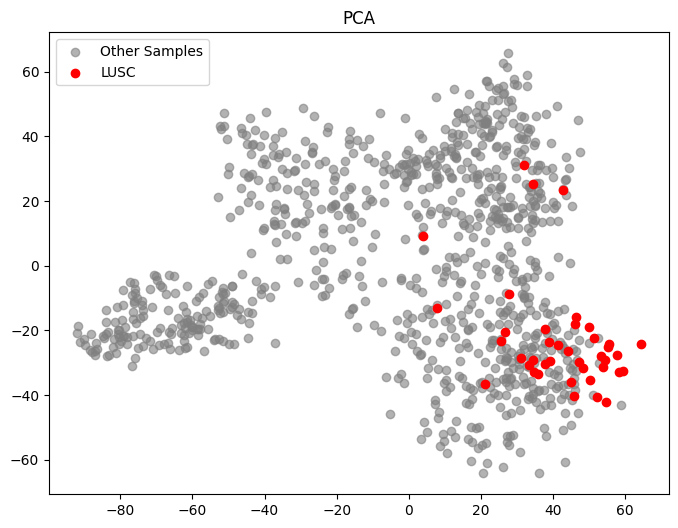

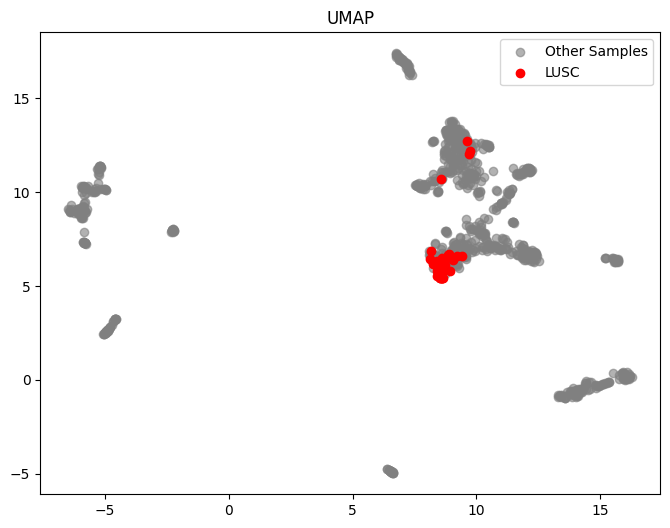

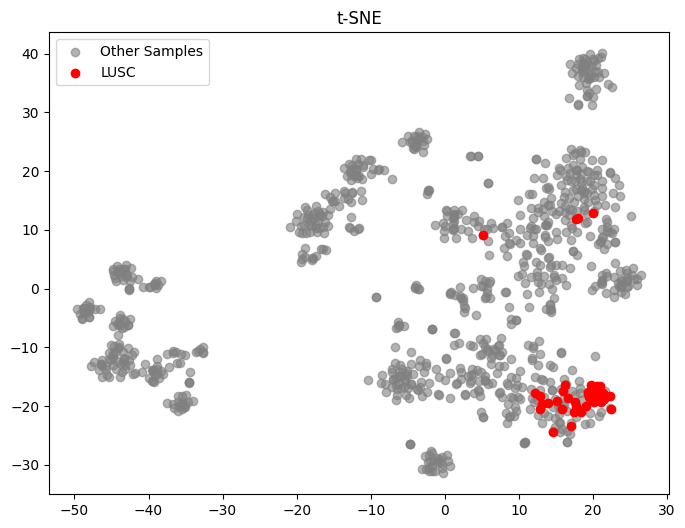

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap

# Assume gdsc_exp_matrix and gdsc_meta are already loaded as DataFrames
# gdsc_exp_matrix: rows are genes, columns are samples
# gdsc_meta: rows are samples, contains 'cancer_type' column

# Step 1: Align data
gdsc_exp_matrix_t = gdsc_exp_matrix.T  # Transpose so samples are rows, genes are columns
class_label = gdsc_meta['cancer_type']

# Step 2: Identify LUSC samples
type_mask = class_label == cancer_type

# Step 3: Perform PCA
pca = PCA(n_components=2)
pca_result_exp = pca.fit_transform(gdsc_exp_matrix_t)

# Step 4: Perform UMAP
umap_model = umap.UMAP(n_components=2, random_state=42)
umap_result_exp = umap_model.fit_transform(gdsc_exp_matrix_t)

# Step 5: Perform t-SNE
tsne_model = TSNE(n_components=2, random_state=42)
tsne_result_exp = tsne_model.fit_transform(gdsc_exp_matrix_t)

# Step 6: Define plotting function
def plot_embedding(embedding, title):
    plt.figure(figsize=(8, 6))

    # Plot non-LUSC samples (grey, opacity 0.6)
    plt.scatter(embedding[~type_mask, 0], embedding[~type_mask, 1],
                c='grey', alpha=0.6, label='Other Samples')

    # Plot LUSC samples (red, opacity 1)
    plt.scatter(embedding[type_mask, 0], embedding[type_mask, 1],
                c='red', alpha=1.0, label=cancer_type)

    plt.title(title)
    plt.legend()
    plt.show()

# Step 7: Plot PCA, UMAP, and t-SNE results
plot_embedding(pca_result_exp, 'PCA')
plot_embedding(umap_result_exp, 'UMAP')
plot_embedding(tsne_result_exp, 't-SNE')


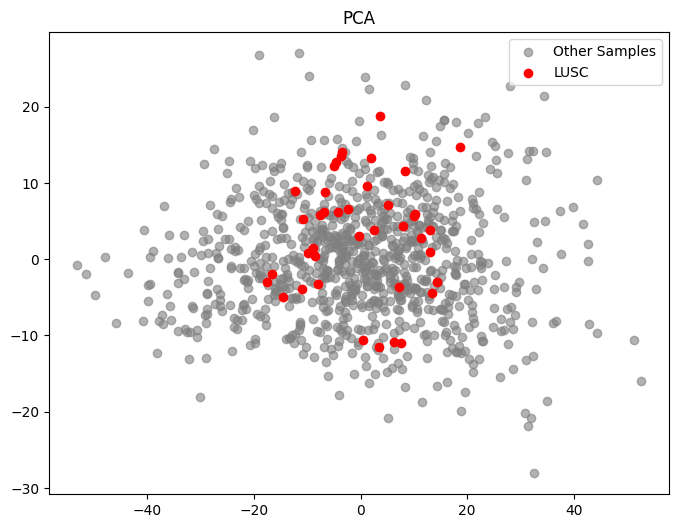

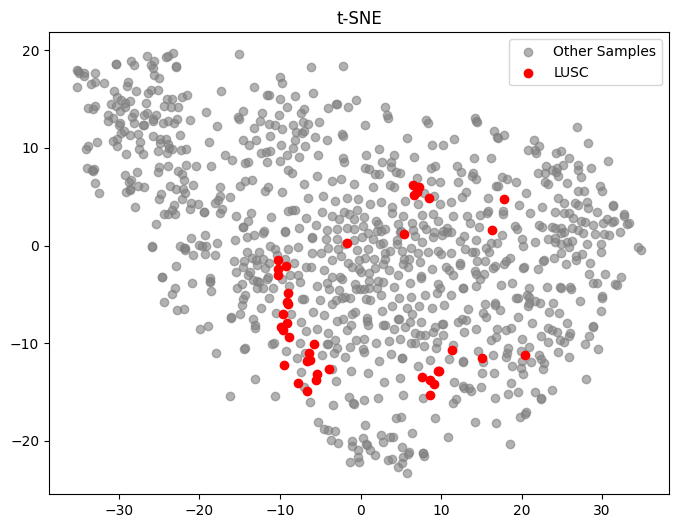

In [ ]:
# plotting IC50 data

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap

# Step 1: Align data
def replace_na_with_median(row):
    median = row.median()
    return row.fillna(median)
ic50_t = ic50.copy()
ic50_t = ic50_t.apply(replace_na_with_median,axis=1)
gdsc_exp_matrix_t = gdsc_exp_matrix.T  # Transpose so samples are rows, genes are columns
gdsc_exp_matrix_t = ic50_t.T  # Transpose so samples are rows, genes are columns
class_label = gdsc_meta['cancer_type']

# Step 2: Identify LUSC samples
type_mask = class_label == cancer_type

# Step 3: Perform PCA
pca = PCA(n_components=2)
pca_result_ic50 = pca.fit_transform(gdsc_exp_matrix_t)

# Step 4: Perform UMAP
#umap_model = umap.UMAP(n_components=2, random_state=42)
#umap_result_ic50 = umap_model.fit_transform(gdsc_exp_matrix_t)

# Step 5: Perform t-SNE
tsne_model = TSNE(n_components=2, random_state=42)
tsne_result_ic50 = tsne_model.fit_transform(gdsc_exp_matrix_t)

# Step 6: Define plotting function
def plot_embedding(embedding, title):
    plt.figure(figsize=(8, 6))

    # Plot non-LUSC samples (grey, opacity 0.6)
    plt.scatter(embedding[~type_mask, 0], embedding[~type_mask, 1],
                c='grey', alpha=0.6, label='Other Samples')

    # Plot LUSC samples (red, opacity 1)
    plt.scatter(embedding[type_mask, 0], embedding[type_mask, 1],
                c='red', alpha=1.0, label=cancer_type)

    plt.title(title)
    plt.legend()
    plt.show()

# Step 7: Plot PCA, UMAP, and t-SNE results
plot_embedding(pca_result_ic50, 'PCA')
#plot_embedding(umap_result_ic50, 'UMAP')
plot_embedding(tsne_result_ic50, 't-SNE')


# display PCA results labelled by cancer type and nearest neighbours

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
from sklearn.neighbors import NearestNeighbors

gdsc_exp_matrix_t = gdsc_exp_matrix.T  # Transpose so samples are rows, genes are columns
class_label = gdsc_meta['cancer_type']
# Identify samples samples
target_mask = class_label == cancer_type
# Find nearest neighbors for LUSC samples
nn_model = NearestNeighbors(n_neighbors=ADD_NEAREST)
nn_model.fit(gdsc_exp_matrix.T)
distances, indices = nn_model.kneighbors(gdsc_exp_matrix.T[target_mask])
nearest_samples = indices[:, 1:]
nearest_mask = class_label == "***"
nearest_mask.values[nearest_samples] = True
nearest_mask.index = gdsc_meta.index
nearest_mask

# Perform PCA
pca = PCA(n_components=2)
pca_result_exp = pca.fit_transform(gdsc_exp_matrix_t)

# Define plotting function
def plot_embedding(embedding, title):
    plt.figure(figsize=(8, 6))

    # Plot non-LUSC samples (grey, opacity 0.6)
    plt.scatter(embedding[~target_mask, 0], embedding[~target_mask, 1],
                c='grey', alpha=0.6, label='Other Samples')

    # Plot nearest samples (orange, opacity 1)
    plt.scatter(embedding[nearest_mask, 0], embedding[nearest_mask, 1],
                c='orange', alpha=1.0, label='Nearest')

    # Plot LUSC samples (red, opacity 1)
    plt.scatter(embedding[target_mask, 0], embedding[target_mask, 1],
                c='red', alpha=1.0, label=cancer_type)

    plt.title(title)
    plt.legend()
    plt.show()

# Step 7: Plot PCA, UMAP, and t-SNE results
plot_embedding(pca_result_exp, 'PCA')

### Standardization Experimentation

In [ ]:
from sklearn.preprocessing import StandardScaler

gdsc_expr = pd.read_csv("gdsc_expression.csv", index_col=0)  # GDSC cell-line expression
tcga_expr = pd.read_csv("tcga_RSEM_gene_tpm.gz", sep="\t", index_col=0)  # TCGA patient expression

# Standardize both datasets
scaler = StandardScaler()

gdsc_scaled = pd.DataFrame(scaler.fit_transform(gdsc_expr.T), 
                           index=gdsc_expr.columns, columns=gdsc_expr.index).T

tcga_scaled = pd.DataFrame(scaler.transform(tcga_expr.T), 
                           index=tcga_expr.columns, columns=tcga_expr.index).T

print("Standardized GDSC Expression:", gdsc_scaled.shape)
print("Standardized TCGA Expression:", tcga_scaled.shape)

In [ ]:
import numpy as np
from scipy.stats import rankdata

def quantile_normalize(df):
    """Perform quantile normalization on a gene expression dataframe."""
    ranked = np.apply_along_axis(rankdata, 1, df)
    mean_ranks = np.mean(np.sort(df.values, axis=1), axis=1)
    norm_df = np.apply_along_axis(lambda x: mean_ranks[x.astype(int) - 1], 1, ranked)
    return pd.DataFrame(norm_df, index=df.index, columns=df.columns)

# Apply quantile normalization
gdsc_qn = quantile_normalize(gdsc_expr)
tcga_qn = quantile_normalize(tcga_expr)

if patient data can be grouped you can tell whether or not their cancer / chemo will be effective / get worse 

bagging model 

ccle - using other cell line datasetes to better select 
or build a model and apply 
for some cancer types there are not many cell lines 

recover gene selection ability 

approach is taking the patient data and mapping back onto cell lines 

bidirectionality 
- prediction becomes independent 
- link structure and prediction - start on 

- 20,000 genes will be expressed / unexpressed
patients will have mutations - few will overlap 
copy number changes 
can be brought in and improve the model -- predict the genes and mutations 


get something that works just with expression data 

copy number information and mutation will be minimal 'from these 5 genes'

graphics and the papers and the chemosensitivity stuff
- looking for any particular gene or model that canges the ic50 values for cell lines 
    - high vs low expression --> ic50 values
    - to stack up as a waterfall barplot 
        go from high expression which one is sensitive and resistant 
        
    - more showing the combination of panel of genes 
        - low expression one one side and high expression on one side --> ic50 

ccle 
- make model more robust to essentially achieve the robustness
- 14 cell lines in the ccle 
- gdsc there are 4 
- 3 overlap so IN TOTAL 15 CELL LINES WITH EXTRA IC50 VALUES TO MAKE IT BETTER 
- problem that you have with the project
    - blackbox that calls out the genes that have the best p-value and tells us which are differentially expressed
    - those that are chemosensitive or resistant 
    - blackbox 

    stuck with looking into the p-value 
    - BLACKBOX 

    ASK ABOUT THE GOOGLE DRIVE 
    - data files 


    gdsc expression matrix 
    - replicate the gdsc matrix with ccle data 

    cell lines annotated

    ccle name of cell line instead of the index 

Questions
1. lnic50 
median as the cutoff and two datapoints close to the line 
2. ic50 
3. noise of non expression 
4. merging the data and how it is organized 
    - first 4 cell lines on gdsc 
    - involved merge on and transpose and reset index 
    

dataframe 

venn diagram
- overlap of genes that significantly express the ccle and gdsc or tcga -- putting through different expression matrix 

heatmap 


feature diagrams 
- cell line expression tcga 